# Model Capacity
In this section, we will explore the impact of different Scale of model capacity to the task effciency and accuracy. 

In [95]:
#@title Set up
!pip install transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
from typing import List, Dict
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image
import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


if torch.cuda.is_available():
   device = 'cuda'
else:
  device = 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the random seed
seed = 174524778
set_seed(seed)

In [97]:
#@title Generate dataset for AND task
# randomly generate two n-bits strings and its ground-truth AND result
class BitWiseDataset(torch.utils.data.Dataset):
  def __init__(self, n, size):
    self.n = n
    self.size = size

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    bits = np.random.randint(low=0, high=2, size=(2, self.n))
    AND = np.logical_and(bits[0], bits[1]).astype(np.int64)
    return torch.tensor(bits.reshape((2*self.n)), dtype=torch.long).to(device), torch.tensor(AND, dtype=torch.long).to(device)

def generate_data_loaders(n, batch_size, data_size = 1000, train_size=0.8):
  dataset = BitWiseDataset(n, size=data_size)
  train_size = int(train_size * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader



Define the universal bit wise transformer

In [98]:
class Bit_wise_transformer(nn.Module):
  def __init__(self, engine, bitLength, input_dim, engine_embed_dim, n_class = 2):
    super().__init__()
    self.n = bitLength
    self.input_embed = nn.Embedding(input_dim, engine_embed_dim)
    self.engine = engine
    self.output_layer = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x):
    embeddings = self.input_embed(x)
    hidden_state = self.engine(inputs_embeds=embeddings).last_hidden_state[:,self.n:]
    logits = self.output_layer(hidden_state)[0]
    return logits

Define the training process

In [99]:
def train(engine_name, train_loader, test_loader, Bit_length, num_epochs = 2):

  # create an instance of the model
  gpt2_engine = GPT2Model.from_pretrained(engine_name)
  for name, param in gpt2_engine.named_parameters():
    # freeze all parameters except the layernorm and positional embeddings 
    if 'ln' in name or 'wpe' in name:
      param.requires_grad = True 
    else:
      param.requires_grad = False


  # Choose the correct embedding size based on the GPT-2 model
  if engine_name == "gpt2":
      engine_embed_dim = 768
  elif engine_name == "gpt2-medium":
      engine_embed_dim = 1024
  elif engine_name == "gpt2-large":
      engine_embed_dim = 1280
  elif engine_name == "gpt2-xl":
      engine_embed_dim = 1600
  else:
      raise ValueError(f"Invalid model name: {engine_name}")

  model = Bit_wise_transformer(
      gpt2_engine, 
      bitLength = Bit_length,
      input_dim = 2, 
      engine_embed_dim = engine_embed_dim
  ).to(device)

  # define the optimizer and loss
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  losses = []
  train_acc = []
  all_val_acc = []
  best_val_acc = 0

  epoch_iterator = trange(num_epochs)
  for epoch in epoch_iterator:
      # Training loop
      running_loss = 0.0
      data_iterator = tqdm(train_loader)
      for i, (inputs, labels) in enumerate(data_iterator):
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels.squeeze())
          accuracy = torch.mean((torch.argmax(outputs, dim=-1) == labels.flatten()).float())
          loss.backward()
          optimizer.step()

          data_iterator.set_postfix(loss=loss.item())

          running_loss += loss.item()
          if (i + 1) % 10 == 0:
              #print(f'Epoch [{epoch + 1}/{num_epochs}], Data [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
              running_loss = 0.0
              losses.append(loss.item())
              train_acc.append(accuracy.item())
        
      # Validation
      val_acc = []
      model.eval()
      with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device=device, dtype=torch.long)
            labels = labels.to(device=device, dtype=torch.long)
            outputs = model(inputs)
            accuracy = torch.mean((torch.argmax(outputs, dim=-1) == labels.flatten()).float())
            val_acc.append(accuracy.item())
      model.train()

      all_val_acc.append(np.mean(val_acc))
      # Save best model
      if np.mean(val_acc) > best_val_acc:
          best_val_acc = np.mean(val_acc)

      epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)


  # plt.plot(losses)
  # plt.title('Train Loss')
  # plt.figure()
  # plt.plot(train_acc)
  # plt.title('Train Accuracy')
  # plt.figure()
  # plt.plot(all_val_acc)
  # plt.title('Val Accuracy')
  del model
  torch.cuda.empty_cache()
  return best_val_acc

## PART A: Does the performance scale with the model size?

In [100]:
engine_list = ["gpt2","gpt2-medium","gpt2-large"]

In [101]:
# train the modified model
Bit_length = 5
Data_size = 100

# training the model
train_loader, test_loader = generate_data_loaders(n=Bit_length, batch_size=1,data_size = Data_size, train_size=0.8)

results = []

for engine_name in engine_list:
  print("We are training the model engine: ", engine_name)
  start_time = time.time()
  best_val_acc = train(engine_name, train_loader, test_loader, Bit_length, num_epochs = 2)
  train_time = time.time() - start_time
  #print("The best val accuracy using the model engine -- ", engine_name, ": ", best_val_acc)

  results.append({
        "model": engine_name,
        "val_accuracy": best_val_acc,
        "train_time": train_time
    })


We are training the model engine:  gpt2


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

We are training the model engine:  gpt2-medium


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

We are training the model engine:  gpt2-large


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [102]:
# Print the results
for result in results:
    print(f"Model: {result['model']}")
    print(f"Accuracy: {result['val_accuracy']}")
    print(f"Training Time: {result['train_time']} seconds")
    print()

Model: gpt2
Accuracy: 0.7400000140070915
Training Time: 16.013365745544434 seconds

Model: gpt2-medium
Accuracy: 0.8600000083446503
Training Time: 28.570152759552002 seconds

Model: gpt2-large
Accuracy: 0.8900000065565109
Training Time: 43.52781796455383 seconds



Results Table:


,model,val_accuracy,train_time
0,gpt2,0.74,16.013366
1,gpt2-medium,0.86,28.570153
2,gpt2-large,0.89,43.527818


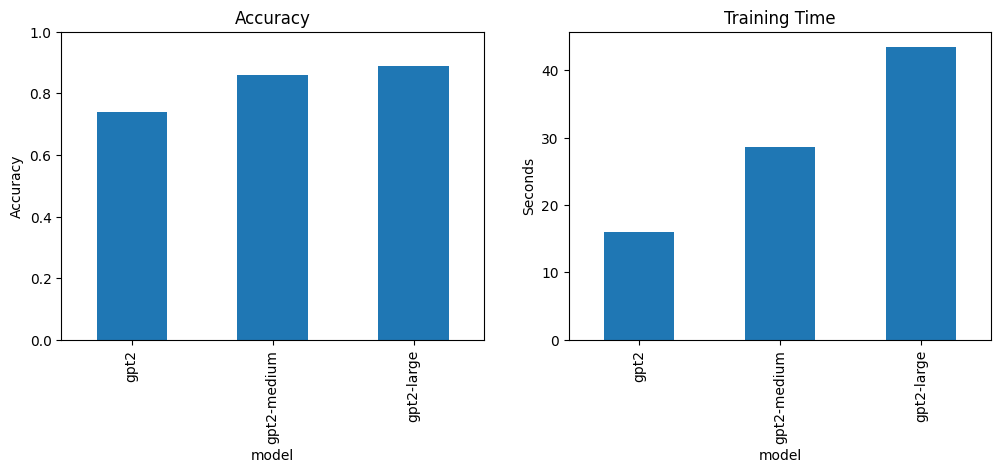

In [103]:
# Create a pandas DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results in a table
print("Results Table:")
display(results_df)

# Plot accuracy and F1 score
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

results_df.plot(x="model", y="val_accuracy", kind="bar", ax=ax[0], legend=False)
ax[0].set_title("Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(0, 1)

results_df.plot(x="model", y="train_time", kind="bar", ax=ax[1], legend=False)
ax[1].set_title("Training Time")
ax[1].set_ylabel("Seconds")

plt.show()
